In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## 1. Convert CSV to Qlib Format

In [2]:
from utils.data_loader import convert_csv_to_qlib, QLIB_DATA_DIR
from pathlib import Path

# ============================================
# CONFIGURE YOUR PERSONAL DATA PATH HERE
# ============================================      
CSV_DATA_DIR = "../data/historical"  # Change this to your CSV data directory

# Verify source directory exists
csv_path = Path(CSV_DATA_DIR)
if csv_path.exists():
    csv_files = list(csv_path.glob("*.csv"))
    print(f"Found {len(csv_files)} CSV files")
    if csv_files:
        print(f"Sample files: {[f.name for f in csv_files[:5]]}")
else:
    print(f"⚠ Directory not found: {csv_path.resolve()}")
    print("Please update CSV_DATA_DIR to point to your data folder")

# Convert CSV data to Qlib binary format
convert_csv_to_qlib(csv_dir=CSV_DATA_DIR)

# Verify output
qlib_path = Path(QLIB_DATA_DIR).expanduser()
if qlib_path.exists():
    instruments = list(qlib_path.glob("*"))
    print(f"\n✓ Qlib data created")
    print(f"  Instruments converted: {len([d for d in instruments if d.is_dir()])}")

Found 10 CSV files
Sample files: ['ACB_ohlc.csv', 'BID_ohlc.csv', 'HPG_ohlc.csv', 'MSN_ohlc.csv', 'MWG_ohlc.csv']
  Read: acb (4737 rows)
  Read: bid (2956 rows)
  Read: hpg (4500 rows)
  Read: msn (4011 rows)
  Read: mwg (2846 rows)
  Read: vcb (4101 rows)
  Read: vhm (1888 rows)
  Read: vic (4541 rows)
  Read: vnm (4955 rows)
  Read: vpb (2071 rows)
  Calendar: 4958 days
  ✓ acb
  ✓ bid
  ✓ hpg
  ✓ msn
  ✓ mwg
  ✓ vcb
  ✓ vhm
  ✓ vic
  ✓ vnm
  ✓ vpb

✓ Converted 10 symbols to Qlib format

✓ Qlib data created
  Instruments converted: 3


## 2. Initialize Qlib

In [4]:
import qlib
from qlib.config import REG_CN

# Initialize Qlib with Vietnamese data
qlib_path = Path(QLIB_DATA_DIR).expanduser()
qlib.init(provider_uri=str(qlib_path), region=REG_CN)
print(f"✓ Qlib initialized")

[896:MainThread](2025-12-08 22:50:16,054) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[896:MainThread](2025-12-08 22:50:16,058) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[896:MainThread](2025-12-08 22:50:16,058) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/Ngoc/.qlib/qlib_data/vn_data')}


✓ Qlib initialized


## 3. Load Data & Check

In [5]:
from qlib.data import D

# List available instruments
instruments = D.instruments(market='all')
print(f"Available instruments: {instruments}")

# Get features for one stock
df = D.features(
    instruments=['vnm'],
    fields=['$close', '$volume', '$high', '$low', '$open'],
    start_time='2020-01-01',
    end_time='2023-12-31'
)
print(f"\nData shape: {df.shape}")
df.head(10)

Available instruments: {'market': 'all', 'filter_pipe': []}

Data shape: (1000, 5)


$close   $volume       $high        $low  \
instrument datetime                                                   
vnm        2020-01-02  117.900002  352700.0  118.199997  116.500000   
           2020-01-03  118.300003  625390.0  119.000000  118.199997   
           2020-01-06  117.400002  495910.0  118.199997  116.800003   
           2020-01-07  118.500000  459520.0  118.800003  117.500000   
           2020-01-08  118.800003  837710.0  118.800003  117.500000   
           2020-01-09  118.599998  624130.0  119.500000  118.400002   
           2020-01-10  118.900002  596280.0  119.199997  118.400002   
           2020-01-13  117.400002  412880.0  119.000000  117.400002   
           2020-01-14  117.800003  335180.0  118.099998  117.099998   
           2020-01-15  117.800003  681740.0  117.900002  117.199997   

                            $open  
instrument datetime                
vnm        2020-01-02  117.000000  
           2020-01-03  118.199997  
           2020-01-06  118.000000  
           2020-01-07  117.500000  
           2020-01-08  118.500000  
           2020-01-09  119.000000  
           2020-01-10  118.599998  
           2020-01-13  119.000000  
           2020-01-14  117.400002  
           2020-01-15  117.800003

## 4. Create Dataset with Alpha158 Features

In [12]:
from qlib.data.dataset import DatasetH
from qlib.contrib.data.handler import Alpha158
from qlib.data import D

# ==============================================
# CONFIGURE DATA SPLIT RATIOS
# ==============================================
TRAIN_RATIO = 0.6   # 60% for training
VALID_RATIO = 0.2   # 20% for validation
TEST_RATIO = 0.2    # 20% for testing

# Get available date range from data
calendar = D.calendar(freq='day')
all_dates = sorted(calendar)
n_dates = len(all_dates)

print(f"Total trading days available: {n_dates}")
print(f"Date range: {all_dates[0]} to {all_dates[-1]}")

# Calculate split indices
train_end_idx = int(n_dates * TRAIN_RATIO)
valid_end_idx = int(n_dates * (TRAIN_RATIO + VALID_RATIO))

# Get split dates
TRAIN_START = all_dates[0].strftime('%Y-%m-%d')
TRAIN_END = all_dates[train_end_idx - 1].strftime('%Y-%m-%d')
VALID_START = all_dates[train_end_idx].strftime('%Y-%m-%d')
VALID_END = all_dates[valid_end_idx - 1].strftime('%Y-%m-%d')
TEST_START = all_dates[valid_end_idx].strftime('%Y-%m-%d')
TEST_END = all_dates[-1].strftime('%Y-%m-%d')

print(f"\nData Split ({TRAIN_RATIO:.0%} / {VALID_RATIO:.0%} / {TEST_RATIO:.0%}):")
print(f"  Train: {TRAIN_START} to {TRAIN_END} ({train_end_idx} days)")
print(f"  Valid: {VALID_START} to {VALID_END} ({valid_end_idx - train_end_idx} days)")
print(f"  Test:  {TEST_START} to {TEST_END} ({n_dates - valid_end_idx} days)")

# Use built-in Alpha158 handler
handler = Alpha158(
    instruments="all",
    start_time=TRAIN_START,
    end_time=TEST_END,
)

# Create dataset
dataset = DatasetH(
    handler=handler,
    segments={
        "train": (TRAIN_START, TRAIN_END),
        "valid": (VALID_START, VALID_END),
        "test": (TEST_START, TEST_END),
    }
)

print(f"\n✓ Dataset created with Alpha158 (158 built-in factors)")

Total trading days available: 4958
Date range: 2006-01-19 00:00:00 to 2025-12-03 00:00:00

Data Split (60% / 20% / 20%):
  Train: 2006-01-19 to 2017-12-21 (2974 days)
  Valid: 2017-12-22 to 2021-12-09 (992 days)
  Test:  2021-12-10 to 2025-12-03 (992 days)


[896:MainThread](2025-12-08 23:04:42,124) INFO - qlib.timer - [log.py:127] - Time cost: 23.441s | Loading data Done
[896:MainThread](2025-12-08 23:04:42,171) INFO - qlib.timer - [log.py:127] - Time cost: 0.013s | DropnaLabel Done
[896:MainThread](2025-12-08 23:04:42,171) INFO - qlib.timer - [log.py:127] - Time cost: 0.013s | DropnaLabel Done
[896:MainThread](2025-12-08 23:04:46,274) INFO - qlib.timer - [log.py:127] - Time cost: 4.102s | CSZScoreNorm Done
[896:MainThread](2025-12-08 23:04:46,274) INFO - qlib.timer - [log.py:127] - Time cost: 4.150s | fit & process data Done
[896:MainThread](2025-12-08 23:04:46,284) INFO - qlib.timer - [log.py:127] - Time cost: 27.602s | Init data Done
[896:MainThread](2025-12-08 23:04:46,274) INFO - qlib.timer - [log.py:127] - Time cost: 4.102s | CSZScoreNorm Done
[896:MainThread](2025-12-08 23:04:46,274) INFO - qlib.timer - [log.py:127] - Time cost: 4.150s | fit & process data Done
[896:MainThread](2025-12-08 23:04:46,284) INFO - qlib.timer - [log.py:1


✓ Dataset created with Alpha158 (158 built-in factors)


In [13]:
# Check dataset
train_data = dataset.prepare("train", col_set=["feature", "label"])
print(f"Train data shape: {train_data.shape}")
print(f"Features: {train_data.columns[:10].tolist()}...")
train_data.head()

Train data shape: (16894, 159)
Features: [('feature', 'KMID'), ('feature', 'KLEN'), ('feature', 'KMID2'), ('feature', 'KUP'), ('feature', 'KUP2'), ('feature', 'KLOW'), ('feature', 'KLOW2'), ('feature', 'KSFT'), ('feature', 'KSFT2'), ('feature', 'OPEN0')]...


feature                                       \
                           KMID      KLEN KMID2  KUP KUP2 KLOW KLOW2   
datetime   instrument                                                  
2006-01-19 vnm         0.000000  0.000000   0.0  0.0  0.0  0.0   0.0   
2006-01-20 vnm        -0.018182  0.018182  -1.0  0.0  0.0  0.0   0.0   
2006-01-23 vnm        -0.027778  0.027778  -1.0  0.0  0.0  0.0   0.0   
2006-01-24 vnm        -0.009524  0.009524  -1.0  0.0  0.0  0.0   0.0   
2006-01-25 vnm         0.019231  0.019231   1.0  0.0  0.0  0.0   0.0   

                                                 ...                      \
                           KSFT KSFT2     OPEN0  ...   VSUMN10   VSUMN20   
datetime   instrument                            ...                       
2006-01-19 vnm         0.000000   0.0  1.000000  ...       NaN       NaN   
2006-01-20 vnm        -0.018182  -1.0  1.018519  ...  0.000000  0.000000   
2006-01-23 vnm        -0.027778  -1.0  1.028571  ...  0.611863  0.611863   
2006-01-24 vnm        -0.009524  -1.0  1.009615  ...  0.654457  0.654457   
2006-01-25 vnm         0.019231   1.0  0.981132  ...  0.674804  0.674804   

                                                                         \
                        VSUMN30   VSUMN60    VSUMD5   VSUMD10   VSUMD20   
datetime   instrument                                                     
2006-01-19 vnm              NaN       NaN       NaN       NaN       NaN   
2006-01-20 vnm         0.000000  0.000000  1.000000  1.000000  1.000000   
2006-01-23 vnm         0.611863  0.611863 -0.223725 -0.223725 -0.223725   
2006-01-24 vnm         0.654457  0.654457 -0.308915 -0.308915 -0.308915   
2006-01-25 vnm         0.674804  0.674804 -0.349608 -0.349608 -0.349608   

                                              label  
                        VSUMD30   VSUMD60    LABEL0  
datetime   instrument                                
2006-01-19 vnm              NaN       NaN -0.027778  
2006-01-20 vnm         1.000000  1.000000 -0.009524  
2006-01-23 vnm        -0.223725 -0.223725  0.019231  
2006-01-24 vnm        -0.308915 -0.308915  0.009434  
2006-01-25 vnm        -0.349608 -0.349608 -0.009346  

[5 rows x 159 columns]

## 5. Train LightGBM Model

In [14]:
from qlib.contrib.model.gbdt import LGBModel

# LightGBM model
model = LGBModel(
    loss="mse",
    learning_rate=0.05,
    num_leaves=31,
    num_boost_round=500,
    early_stopping_rounds=50,
    verbose_eval=100,
)

# Train
model.fit(dataset)
print("\n✓ Model trained")

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.785224	valid's l2: 0.898593
[20]	train's l2: 0.785224	valid's l2: 0.898593
[40]	train's l2: 0.753394	valid's l2: 0.900029
[40]	train's l2: 0.753394	valid's l2: 0.900029
Early stopping, best iteration is:
[4]	train's l2: 0.814692	valid's l2: 0.898251

✓ Model trained
Early stopping, best iteration is:
[4]	train's l2: 0.814692	valid's l2: 0.898251

✓ Model trained


In [15]:
# Predict
pred = model.predict(dataset, segment="test")
print(f"Predictions shape: {pred.shape}")
pred.head(20)

Predictions shape: (9920,)


datetime    instrument
2021-12-10  acb           0.005831
            bid           0.005831
            hpg           0.011081
            msn           0.007801
            mwg           0.007801
            vcb           0.007372
            vhm           0.004339
            vic           0.008774
            vnm           0.004339
            vpb          -0.016620
2021-12-13  acb           0.001163
            bid           0.005831
            hpg           0.011081
            msn           0.007801
            mwg           0.000191
            vcb           0.007372
            vhm           0.009006
            vic           0.013441
            vnm           0.004339
            vpb           0.004739
dtype: float64

## 6. Backtest

In [16]:
# Simple backtest without Qlib's backtest module (to avoid benchmark issue)
from qlib.data import D

# Get predictions
test_pred = pred.copy()
if isinstance(test_pred, pd.Series):
    test_pred = test_pred.to_frame(name='score')
else:
    test_pred.columns = ['score']

# Get list of instruments from predictions
instruments_list = test_pred.index.get_level_values('instrument').unique().tolist()
print(f"Instruments in test: {instruments_list}")

# Get close prices for test period
close_prices = D.features(
    instruments=instruments_list,
    fields=['$close'],
    start_time=TEST_START,
    end_time=TEST_END
)
close_prices.columns = ['close']

# Calculate daily returns
returns_df = close_prices.copy()
returns_df['return'] = returns_df.groupby(level='instrument')['close'].pct_change()

# Merge predictions with returns
backtest_df = test_pred.join(returns_df[['return']], how='inner')
backtest_df = backtest_df.dropna()

print(f"Backtest data shape: {backtest_df.shape}")
print(f"Date range: {backtest_df.index.get_level_values('datetime').min()} to {backtest_df.index.get_level_values('datetime').max()}")
backtest_df.head(10)

Instruments in test: ['acb', 'bid', 'hpg', 'msn', 'mwg', 'vcb', 'vhm', 'vic', 'vnm', 'vpb']
Backtest data shape: (9910, 2)
Date range: 2021-12-13 00:00:00 to 2025-12-03 00:00:00
Backtest data shape: (9910, 2)
Date range: 2021-12-13 00:00:00 to 2025-12-03 00:00:00


score    return
datetime   instrument                    
2021-12-13 acb         0.001163  0.000000
           bid         0.005831  0.020179
           hpg         0.011081  0.001075
           msn         0.007801  0.014964
           mwg         0.000191  0.005966
           vcb         0.007372 -0.004000
           vhm         0.009006  0.014833
           vic         0.013441  0.000970
           vnm         0.004339  0.001159
           vpb         0.004739 -0.011173

In [17]:
# Simple Top-K Strategy Backtest
TOPK = 3

# Group by date and select top-k stocks
daily_returns = []

for date, group in backtest_df.groupby(level='datetime'):
    # Select top-k stocks by predicted score
    top_stocks = group.nlargest(TOPK, 'score')
    
    # Equal weight portfolio return
    portfolio_return = top_stocks['return'].mean()
    daily_returns.append({'date': date, 'return': portfolio_return})

# Create portfolio returns series
portfolio_df = pd.DataFrame(daily_returns).set_index('date')
portfolio_df = portfolio_df.dropna()

# Calculate metrics
returns = portfolio_df['return']
total_return = (1 + returns).prod() - 1
n_days = len(returns)
annual_return = (1 + total_return) ** (252 / n_days) - 1 if n_days > 0 else 0
volatility = returns.std() * np.sqrt(252)
sharpe = annual_return / volatility if volatility > 0 else 0

# Max drawdown
cum_returns = (1 + returns).cumprod()
rolling_max = cum_returns.expanding().max()
drawdown = (cum_returns - rolling_max) / rolling_max
max_dd = drawdown.min()

# Win rate
win_rate = (returns > 0).mean()

print("="*50)
print(f"BACKTEST RESULTS (Top-{TOPK} Strategy)")
print("="*50)
print(f"{'Period':25}: {returns.index.min().strftime('%Y-%m-%d')} to {returns.index.max().strftime('%Y-%m-%d')}")
print(f"{'Trading Days':25}: {n_days}")
print(f"{'Total Return':25}: {total_return:.2%}")
print(f"{'Annual Return':25}: {annual_return:.2%}")
print(f"{'Volatility (Annual)':25}: {volatility:.2%}")
print(f"{'Sharpe Ratio':25}: {sharpe:.2f}")
print(f"{'Max Drawdown':25}: {max_dd:.2%}")
print(f"{'Win Rate':25}: {win_rate:.2%}")

BACKTEST RESULTS (Top-3 Strategy)
Period                   : 2021-12-13 to 2025-12-03
Trading Days             : 991
Total Return             : -97.64%
Annual Return            : -61.44%
Volatility (Annual)      : 28.23%
Sharpe Ratio             : -2.18
Max Drawdown             : -98.16%
Win Rate                 : 41.78%


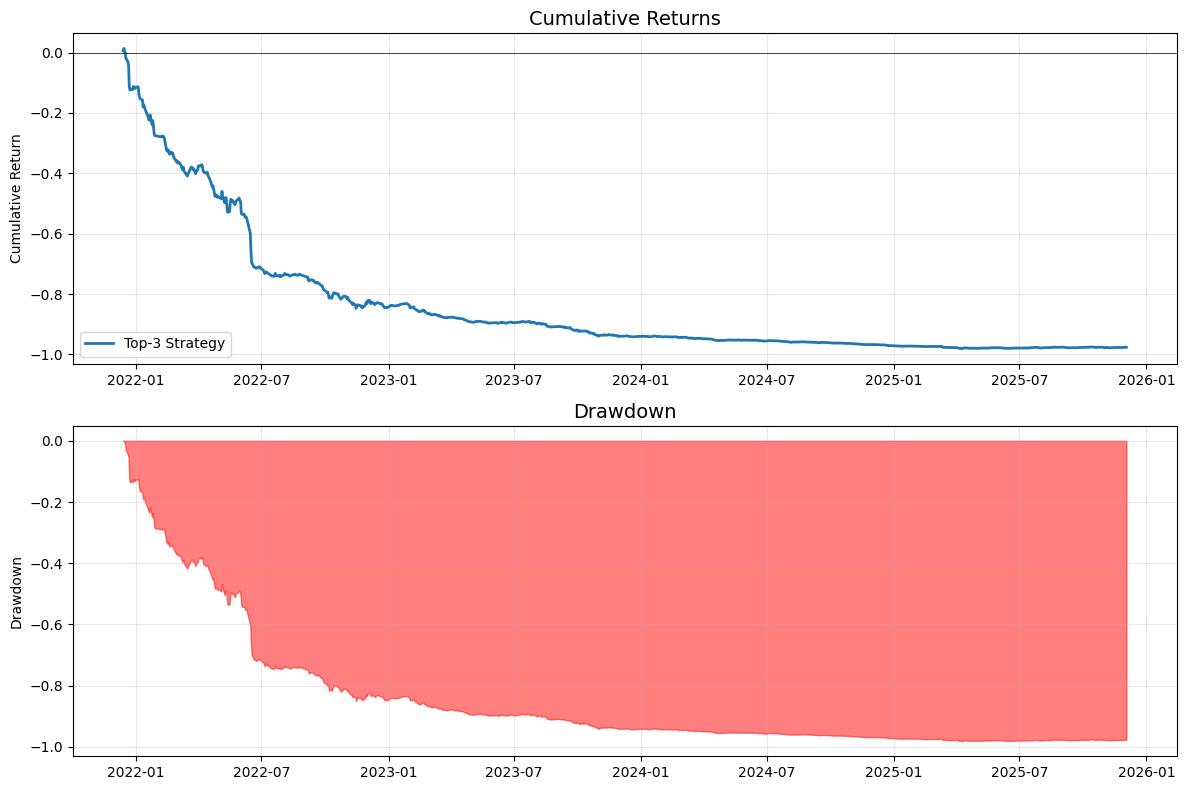

In [18]:
# Plot cumulative returns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Cumulative returns
cum_ret = (1 + portfolio_df['return']).cumprod() - 1
axes[0].plot(cum_ret.index, cum_ret.values, label=f'Top-{TOPK} Strategy', linewidth=2)
axes[0].set_title('Cumulative Returns', fontsize=14)
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Drawdown
axes[1].fill_between(drawdown.index, drawdown.values, 0, alpha=0.5, color='red')
axes[1].set_title('Drawdown', fontsize=14)
axes[1].set_ylabel('Drawdown')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance

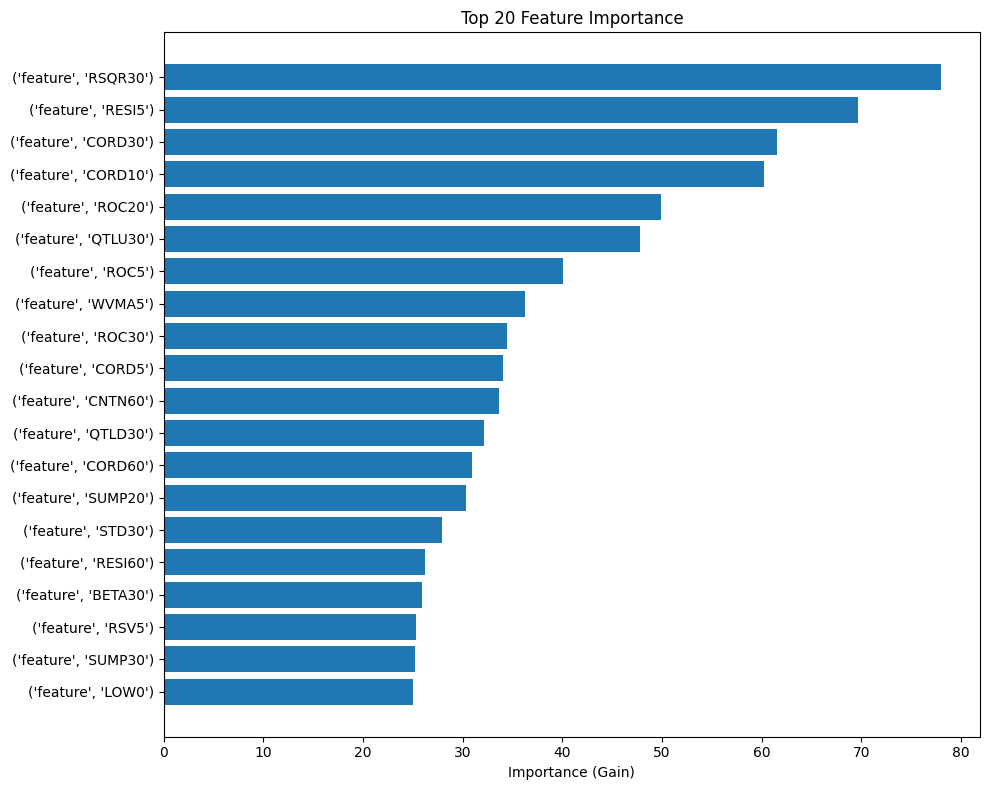


Top 10 Features:
          feature  importance
(feature, RSQR30)   78.020701
 (feature, RESI5)   69.724401
(feature, CORD30)   61.586800
(feature, CORD10)   60.211801
 (feature, ROC20)   49.916511
(feature, QTLU30)   47.836001
  (feature, ROC5)   40.035200
 (feature, WVMA5)   36.248800
 (feature, ROC30)   34.402660
 (feature, CORD5)   34.065500


In [19]:
# Get feature importance from LightGBM
try:
    # Try to get feature importance
    if hasattr(model, 'model') and model.model is not None:
        importance = model.model.feature_importance(importance_type='gain')
        
        # Get feature names from train_data (exclude label column)
        feature_cols = [col for col in train_data.columns if col != 'label']
        
        # Create DataFrame
        fi_df = pd.DataFrame({
            'feature': feature_cols[:len(importance)],
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        # Plot top 20
        plt.figure(figsize=(10, 8))
        top_features = fi_df.head(20)
        plt.barh(range(len(top_features)), top_features['importance'].values)
        plt.yticks(range(len(top_features)), top_features['feature'].values)
        plt.xlabel('Importance (Gain)')
        plt.title('Top 20 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Features:")
        print(fi_df.head(10).to_string(index=False))
    else:
        print("Model not available")
except Exception as e:
    print(f"Could not get feature importance: {e}")

## 8. Quick Alternative: Using Custom Alpha Expressions

In [ ]:
# Custom alpha factors using Qlib expressions
custom_fields = [
    # Momentum
    "Ref($close, -20) / $close - 1",           # 20-day return
    "Ref($close, -60) / $close - 1",           # 60-day return
    
    # Volume
    "Mean($volume, 5) / Mean($volume, 20)",    # Volume ratio
    "Std($volume, 20) / Mean($volume, 20)",    # Volume volatility
    
    # Price
    "($high - $low) / $close",                 # Daily range
    "($close - $open) / ($high - $low + 1e-8)", # Intraday momentum
    
    # Moving Averages
    "$close / Mean($close, 20) - 1",           # Price vs MA20
    "Mean($close, 5) / Mean($close, 20) - 1",  # MA5/MA20
    
    # RSI-like
    "Rank(Ref($close, -5) / $close - 1)",      # Rank of 5-day return
]

# Get custom features
custom_df = D.features(
    instruments='all',
    fields=custom_fields,
    start_time='2023-01-01',
    end_time='2023-12-31'
)

print(f"Custom features shape: {custom_df.shape}")
custom_df.head(10)